# The Confusion Matrix

I want to predict if a person will get a heart failure based on some personal and medical information. 

In [2]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

data = pd.read_csv('data/heart.csv')
label_encoder = LabelEncoder()
data["Sex"] = label_encoder.fit_transform(data["Sex"])
data["ChestPainType"] = label_encoder.fit_transform(data["ChestPainType"])
data["RestingECG"] = label_encoder.fit_transform(data["RestingECG"])
data["ExerciseAngina"] = label_encoder.fit_transform(data["ExerciseAngina"])
data["ST_Slope"] = label_encoder.fit_transform(data["ST_Slope"])

In [5]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,1,140,289,0,1,172,0,0.0,2
1,49,0,2,160,180,0,1,156,0,1.0,1
2,37,1,1,130,283,0,2,98,0,0.0,2
3,48,0,0,138,214,0,1,108,1,1.5,1
4,54,1,2,150,195,0,1,122,0,0.0,2


I want to solve the machine learning problem, so I decide to use a SVC classifier

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.6847826086956522


The accuracy is way to sumarize the classification result, but it hides the per-class details of the result. For showing it, we need the **Confusion Matrix**.


In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred)

print(cm)

[[54 23]
 [35 72]]


Let show it using matplotlib

In [46]:
def show_confusion_matrix(m, classes, figsize=(4,4), ax=None, title=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    if title is None:
        Title = "Confusion Matrix"

    # Plot the confusion matrix
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)

    # Add labels to each cell in the matrix
    thresh = m.max() / 2.
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            ax.text(j, i, m[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
from functools import partial
show_cm_heart = partial(show_confusion_matrix, classes=['normal', 'heart_disease'])

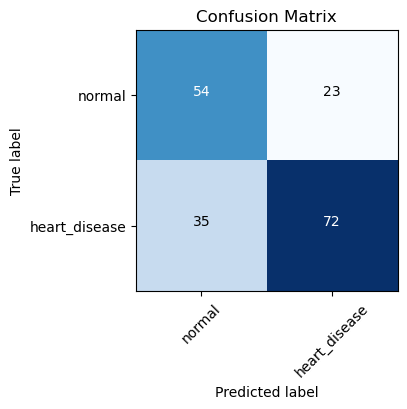

In [38]:
show_cm_heart(cm)

In [31]:
# Real counts per class
y_test.value_counts()

HeartDisease
1    107
0     77
Name: count, dtype: int64

When interpreting the confusion matrix for class 0, it is important to consider that class 0 represents the positive class, while class 1 represents the negative class

Note that the accuracy (ratio of correct classifications) can be calculted as:

Accuracy: (TP + TN) / N

In [32]:
(54+72) / len(X_test)

0.6847826086956522

Now, we can compare the behavior of different models in the dataset.

In [33]:
# A decision tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
cm_tree = confusion_matrix(y_test, y_pred)

In [35]:
# A KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred)

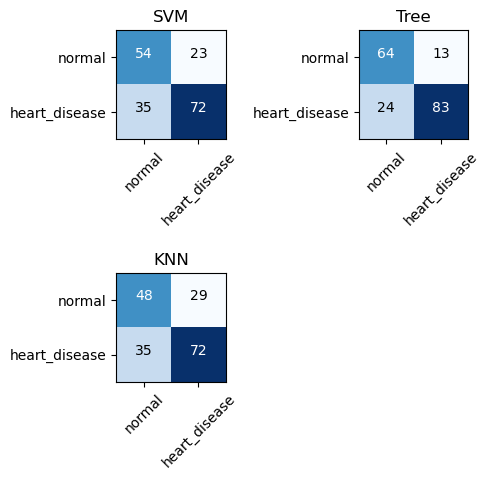

In [62]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
show_cm_heart(cm, ax=axes[0, 0], title="SVM")
show_cm_heart(cm_tree, ax=axes[0, 1], title="Tree")
show_cm_heart(cm_knn, ax=axes[1, 0], title="KNN")
axes[1, 1].axis('off')
plt.tight_layout()
plt.show()


There are certain problems, such as the one mentioned, where the significance of errors is not equal:

- Misdiagnosing a healthy person as sick can be rectified through additional analysis.
- Misdiagnosing a sick person as healthy may lead to a lack of appropriate treatment, potentially worsening their condition.

To modify the algorith behavior in those classes, we need to assign weights to classes, like in this example:

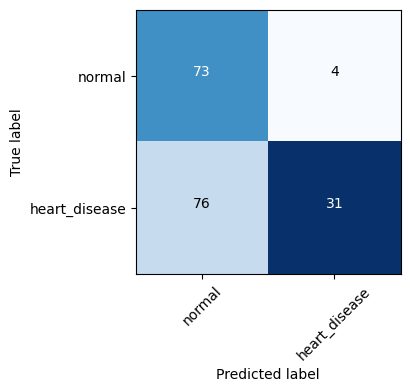

In [77]:
# Class normal is more important
class_weights = {0: 0.7, 1: 0.3}
clf = SVC(class_weight=class_weights)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
cm_tree = confusion_matrix(y_test, y_pred)
show_cm_heart(cm_tree)

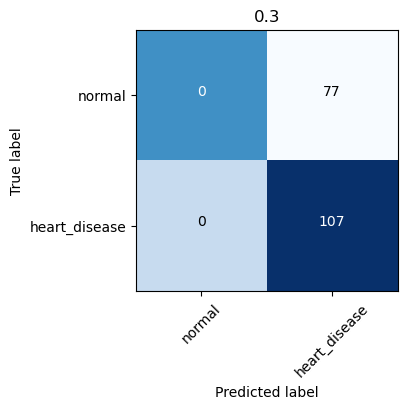

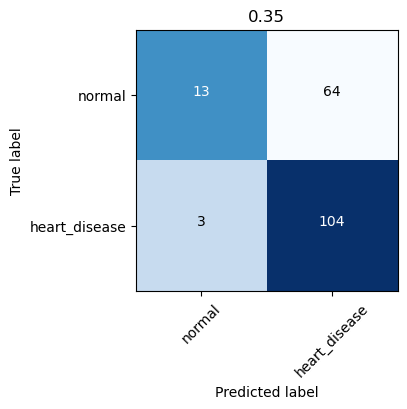

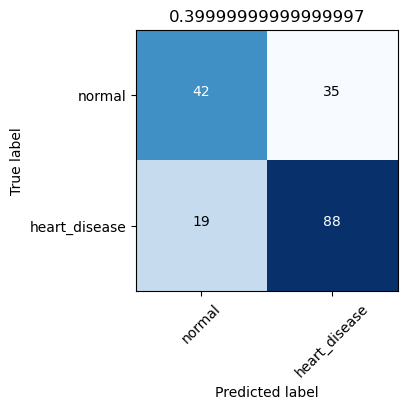

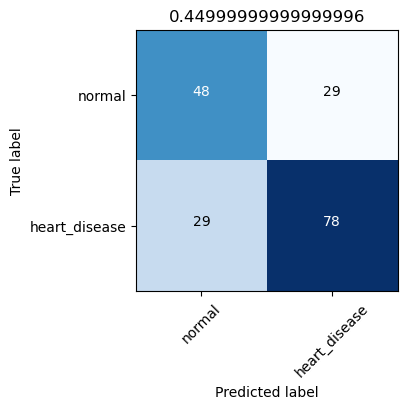

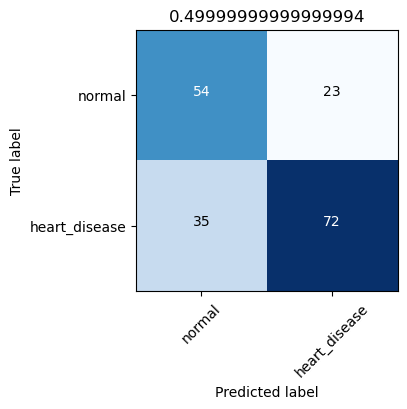

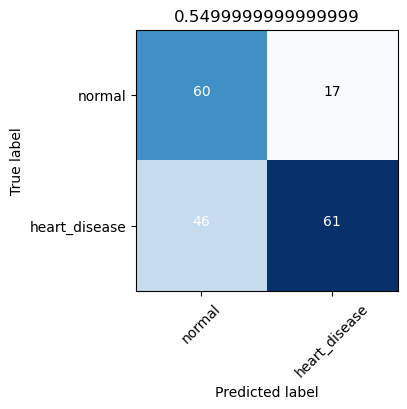

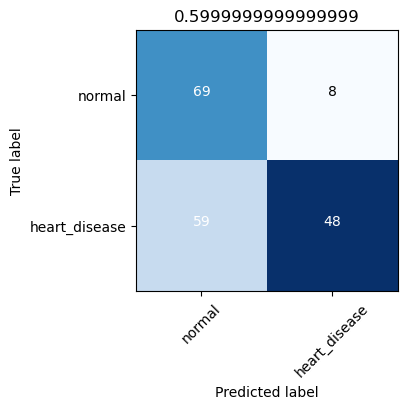

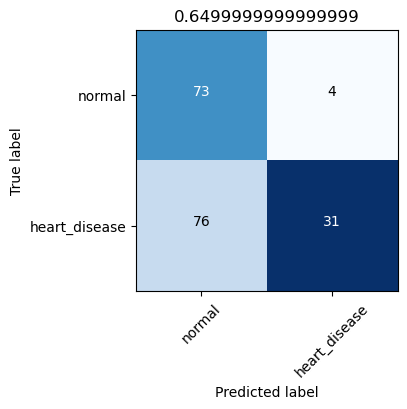

In [85]:
# Lets play with different importances:
for d in np.arange(0.3, 0.7, 0.05):
    class_weights = {0: d, 1: 1-d}
    clf = SVC(class_weight=class_weights)
    clf = clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    cm_tree = confusion_matrix(y_test, y_pred)
    show_cm_heart(cm_tree, title=str(d))

Note: This analysis can be performed using the confusion matrix

## Confusion matrixes with more than two classes

Lets use dataset Vehicle, from the UCI repository. The task is to classify a given silhouette as one of four types of vehicle, using  a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles. 

In [90]:
db = pd.read_csv('data/vehicle.txt', header=None)
db.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,van,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197
1,van,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199
2,saab,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196


In [91]:
X = db.iloc[:, 1:]
y = db.iloc[:, 0]
X.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196


In [92]:
y.value_counts()

0
bus     218
saab    217
opel    212
van     199
Name: count, dtype: int64

Lets train a SVM classifier

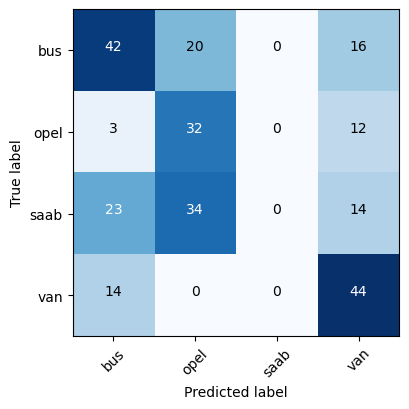

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = SVC()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

show_confusion_matrix(cm, classes=["bus","opel","saab","van"])

In [98]:
y_test.value_counts()

0
bus     78
saab    71
van     58
opel    47
Name: count, dtype: int64

**Note**: 
- No car is assigned to the saab class
- The largest confusion appears betwen saab and open, what makes sense